<div style="margin-bottom: 32px;">
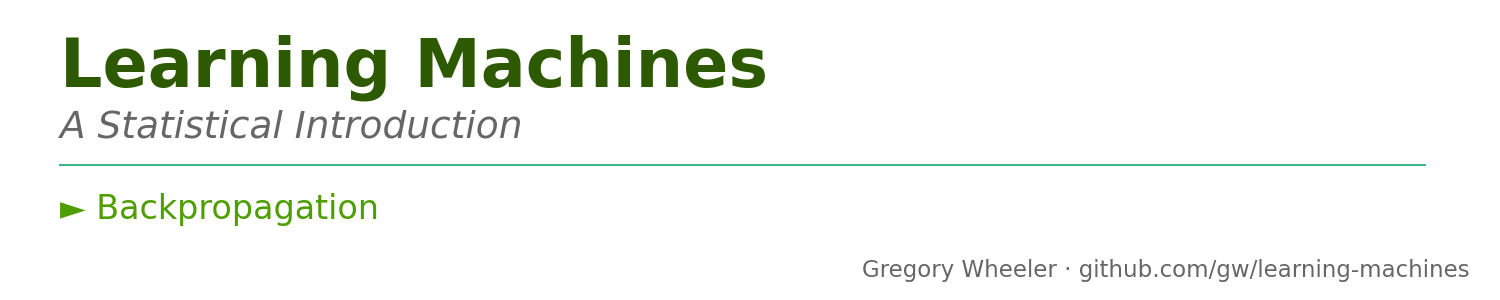
</div>


# Backpropagation: Forward and Backward Pass

Backpropagation is the algorithm that makes neural networks trainable. This notebook implements it from scratch on a tiny network, making the chain rule concrete: values flow forward through the network, then gradients flow backward. Numerical gradient checking confirms the analytical gradients are correct.

**What computation adds**: The textbook derives the gradients symbolically; here we trace actual numbers through each node. Watching δ values propagate backward demystifies what "training a neural network" really means at the computational level.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Circle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

# Use notebook style
import mlone_theme as mt
mt.set_notebook_mode()

# Colors
GREEN = '#4F9E00'      # Primary (forward pass)
BLUE = '#076FA1'       # Secondary  
RED = '#E3120B'        # Backward pass
GRAY = '#666666'
GRAY_LIGHT = '#CCCCCC'

## A Tiny Network

We'll work with the simplest possible network that still demonstrates backpropagation:

- **One input** $x$
- **One hidden unit** with sigmoid activation
- **One linear output** (no activation)
- **Squared error loss**

This matches the worked example in the textbook. The network computes:

$$z^{[1]} = w^{[1]} x + b^{[1]}$$
$$a^{[1]} = \sigma(z^{[1]})$$
$$z^{[2]} = w^{[2]} a^{[1]} + b^{[2]}$$
$$\hat{y} = z^{[2]}$$
$$L = \frac{1}{2}(y - \hat{y})^2$$

In [ ]:
def sigmoid(z):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    """Derivative of sigmoid: σ'(z) = σ(z)(1 - σ(z))."""
    s = sigmoid(z)
    return s * (1 - s)

In [ ]:
class TinyNetwork:
    """
    A minimal network: input -> hidden (sigmoid) -> output (linear).
    Stores all intermediate values for visualization.
    """
    
    def __init__(self, w1=0.5, b1=0.1, w2=0.8, b2=-0.2):
        # Layer 1 parameters
        self.w1 = w1
        self.b1 = b1
        # Layer 2 parameters
        self.w2 = w2
        self.b2 = b2
        
        # Will store intermediate values after forward pass
        self.x = None
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.y_hat = None
        self.y = None
        self.loss = None
        
        # Will store gradients after backward pass
        self.dL_dy_hat = None
        self.delta2 = None
        self.delta1 = None
        self.dL_dw2 = None
        self.dL_db2 = None
        self.dL_dw1 = None
        self.dL_db1 = None
    
    def forward(self, x, y):
        """Forward pass: compute predictions and loss."""
        self.x = x
        self.y = y
        
        # Layer 1: linear + sigmoid
        self.z1 = self.w1 * x + self.b1
        self.a1 = sigmoid(self.z1)
        
        # Layer 2: linear (no activation)
        self.z2 = self.w2 * self.a1 + self.b2
        self.y_hat = self.z2  # Linear output
        
        # Loss: squared error
        self.loss = 0.5 * (y - self.y_hat) ** 2
        
        return self.y_hat, self.loss
    
    def backward(self):
        """Backward pass: compute all gradients."""
        # Gradient of loss w.r.t. prediction
        self.dL_dy_hat = -(self.y - self.y_hat)
        
        # Delta at output layer (linear activation, so derivative = 1)
        self.delta2 = self.dL_dy_hat * 1  # δ² = ∂L/∂z²
        
        # Gradients for layer 2 parameters
        self.dL_dw2 = self.delta2 * self.a1
        self.dL_db2 = self.delta2
        
        # Delta at hidden layer
        # δ¹ = w² · δ² · σ'(z¹)
        self.delta1 = self.w2 * self.delta2 * sigmoid_derivative(self.z1)
        
        # Gradients for layer 1 parameters
        self.dL_dw1 = self.delta1 * self.x
        self.dL_db1 = self.delta1
        
        return {
            'dL/dw2': self.dL_dw2,
            'dL/db2': self.dL_db2,
            'dL/dw1': self.dL_dw1,
            'dL/db1': self.dL_db1
        }

## Activation Functions and Their Derivatives

Before diving into the worked example, let's visualize the activation functions discussed in the textbook. The choice of activation function has a profound impact on training—specifically, on how gradients flow backward through the network.

The **sigmoid** we use in this notebook has a well-known problem: its derivative is near zero for inputs far from zero, causing gradients to *vanish* as they propagate backward through many layers. **ReLU** and its variants address this by maintaining a constant gradient (or near-constant) for positive inputs.

In [ ]:
# Activation functions and their derivatives
def tanh(z):
    return np.tanh(z)

def tanh_derivative(z):
    return 1 - np.tanh(z)**2

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def leaky_relu_derivative(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)

# Visualize
z = np.linspace(-4, 4, 200)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: activation functions
ax = axes[0]
ax.plot(z, sigmoid(z), label='Sigmoid', color='#076FA1', linewidth=2)
ax.plot(z, tanh(z), label='Tanh', color='#2FC1D3', linewidth=2)
ax.plot(z, relu(z), label='ReLU', color='#4F9E00', linewidth=2)
ax.plot(z, leaky_relu(z), label='Leaky ReLU', color='#3EB489', linewidth=2, linestyle='--')
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
ax.set_xlabel('z')
ax.set_ylabel('σ(z)')
ax.set_title('Activation Functions')
ax.legend(loc='upper left')
ax.set_ylim(-1.5, 4)

# Right: derivatives
ax = axes[1]
ax.plot(z, sigmoid_derivative(z), label="Sigmoid'", color='#076FA1', linewidth=2)
ax.plot(z, tanh_derivative(z), label="Tanh'", color='#2FC1D3', linewidth=2)
ax.plot(z, relu_derivative(z), label="ReLU'", color='#4F9E00', linewidth=2)
ax.plot(z, leaky_relu_derivative(z), label="Leaky ReLU'", color='#3EB489', linewidth=2, linestyle='--')
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
ax.set_xlabel('z')
ax.set_ylabel("σ'(z)")
ax.set_title('Derivatives (Gradient Flow)')
ax.legend(loc='upper right')
ax.set_ylim(-0.1, 1.2)

plt.tight_layout()
plt.show()

**Key observations:**

- **Sigmoid** and **tanh** derivatives peak at 0.25 and 1.0, respectively, and decay rapidly toward zero. In deep networks, multiplying many such small derivatives causes the *vanishing gradient problem*.
- **ReLU** has derivative exactly 1 for positive inputs—gradients pass through unchanged. The trade-off: "dead" neurons when inputs are always negative.
- **Leaky ReLU** allows a small gradient (α = 0.01) for negative inputs, preventing completely dead neurons.

We'll use sigmoid in the worked example below because its derivative has a nice closed form (σ'(z) = σ(z)(1 - σ(z))), making the math transparent. Modern deep networks typically use ReLU variants.

## The Worked Example

Using the same values as the textbook:

In [ ]:
# Initialize network with textbook values
net = TinyNetwork(w1=0.5, b1=0.1, w2=0.8, b2=-0.2)

# Input and target
x = 1.0
y = 0.5

# Forward pass
y_hat, loss = net.forward(x, y)

print("=== Forward Pass ===")
print(f"Input:  x = {x}")
print(f"Target: y = {y}")
print()
print(f"z¹ = w¹·x + b¹ = {net.w1}·{x} + {net.b1} = {net.z1:.3f}")
print(f"a¹ = σ(z¹) = σ({net.z1:.3f}) = {net.a1:.3f}")
print(f"z² = w²·a¹ + b² = {net.w2}·{net.a1:.3f} + {net.b2} = {net.z2:.3f}")
print(f"ŷ  = z² = {net.y_hat:.3f}")
print(f"L  = ½(y - ŷ)² = ½({y} - {net.y_hat:.3f})² = {net.loss:.4f}")

In [ ]:
# Backward pass
gradients = net.backward()

print("=== Backward Pass ===")
print(f"∂L/∂ŷ = -(y - ŷ) = -({y} - {net.y_hat:.3f}) = {net.dL_dy_hat:.3f}")
print()
print(f"δ² = ∂L/∂z² = {net.delta2:.3f}  (linear output, derivative = 1)")
print()
print(f"δ¹ = w²·δ²·σ'(z¹)")
print(f"   = {net.w2}·({net.delta2:.3f})·[{net.a1:.3f}·(1-{net.a1:.3f})]")
print(f"   = {net.delta1:.4f}")
print()
print("=== Gradients ===")
print(f"∂L/∂w² = δ²·a¹ = {net.delta2:.3f}·{net.a1:.3f} = {net.dL_dw2:.4f}")
print(f"∂L/∂b² = δ² = {net.dL_db2:.4f}")
print(f"∂L/∂w¹ = δ¹·x = {net.delta1:.4f}·{x} = {net.dL_dw1:.4f}")
print(f"∂L/∂b¹ = δ¹ = {net.dL_db1:.4f}")

## Visualizing Forward and Backward Passes

The animation below shows:
1. **Forward pass** (green): values propagate left to right
2. **Backward pass** (red): gradients propagate right to left

Watch how each value depends on the previous ones, and how gradients flow back through the same path.

In [ ]:
def create_backprop_animation(net):
    """
    Create an animation showing forward and backward passes.
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Node positions
    nodes = {
        'x': (1, 5),
        'z1': (4, 5),
        'a1': (7, 5),
        'z2': (10, 5),
        'y_hat': (13, 5),
        'L': (13, 2.5),
        'y': (10, 2.5)
    }
    
    # Values and gradients for each node
    forward_values = {
        'x': f'x = {net.x:.2f}',
        'z1': f'z¹ = {net.z1:.3f}',
        'a1': f'a¹ = {net.a1:.3f}',
        'z2': f'z² = {net.z2:.3f}',
        'y_hat': f'ŷ = {net.y_hat:.3f}',
        'L': f'L = {net.loss:.4f}',
        'y': f'y = {net.y:.2f}'
    }
    
    backward_values = {
        'y_hat': f'∂L/∂ŷ = {net.dL_dy_hat:.3f}',
        'z2': f'δ² = {net.delta2:.3f}',
        'a1': f'∂L/∂a¹ = {net.w2 * net.delta2:.3f}',
        'z1': f'δ¹ = {net.delta1:.4f}',
    }
    
    # Edge labels
    edge_labels = {
        ('x', 'z1'): f'w¹={net.w1}',
        ('z1', 'a1'): 'σ(·)',
        ('a1', 'z2'): f'w²={net.w2}',
        ('z2', 'y_hat'): '',
        ('y_hat', 'L'): '',
        ('y', 'L'): ''
    }
    
    # Animation frames
    # Forward: x -> z1 -> a1 -> z2 -> y_hat -> L
    # Backward: L -> y_hat -> z2 -> a1 -> z1
    forward_sequence = ['x', 'z1', 'a1', 'z2', 'y_hat', 'L']
    backward_sequence = ['y_hat', 'z2', 'a1', 'z1']
    
    total_frames = len(forward_sequence) + len(backward_sequence) + 2  # +2 for pause
    
    def draw_node(ax, name, pos, value_text, color, alpha=1.0, show_value=True):
        """Draw a node with its value."""
        x, y = pos
        circle = Circle((x, y), 0.6, facecolor='white', edgecolor=color, 
                        linewidth=3, alpha=alpha, zorder=10)
        ax.add_patch(circle)
        
        # Node label
        label_map = {'x': 'x', 'z1': 'z¹', 'a1': 'a¹', 'z2': 'z²', 
                    'y_hat': 'ŷ', 'L': 'L', 'y': 'y'}
        ax.text(x, y, label_map[name], ha='center', va='center', 
               fontsize=16, fontweight='bold', color=color, alpha=alpha)
        
        # Value below node
        if show_value:
            ax.text(x, y - 1.0, value_text, ha='center', va='top',
                   fontsize=11, color=color, alpha=alpha)
    
    def draw_edge(ax, start, end, label='', color=GRAY, alpha=1.0, offset=0):
        """Draw an edge between nodes."""
        x1, y1 = nodes[start]
        x2, y2 = nodes[end]
        
        # Adjust for node radius
        dx = x2 - x1
        dy = y2 - y1
        dist = np.sqrt(dx**2 + dy**2)
        x1 += 0.6 * dx / dist
        y1 += 0.6 * dy / dist + offset
        x2 -= 0.6 * dx / dist
        y2 -= 0.6 * dy / dist + offset
        
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                   arrowprops=dict(arrowstyle='->', color=color, lw=2, alpha=alpha))
        
        if label:
            mx, my = (x1 + x2) / 2, (y1 + y2) / 2 + 0.3
            ax.text(mx, my, label, ha='center', va='bottom', 
                   fontsize=10, color=color, alpha=alpha)
    
    def animate(frame):
        ax.clear()
        ax.set_xlim(-0.5, 15)
        ax.set_ylim(0, 7)
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Title
        if frame < len(forward_sequence):
            ax.set_title('Forward Pass: Computing Values', fontsize=18, 
                        fontweight='bold', color=GREEN, pad=20)
        elif frame < len(forward_sequence) + 1:
            ax.set_title('Forward Pass Complete', fontsize=18,
                        fontweight='bold', color=GREEN, pad=20)
        else:
            ax.set_title('Backward Pass: Computing Gradients', fontsize=18,
                        fontweight='bold', color=RED, pad=20)
        
        # Determine which nodes are active
        if frame < len(forward_sequence):
            # Forward pass
            active_forward = forward_sequence[:frame + 1]
            active_backward = []
        elif frame == len(forward_sequence):
            # Pause after forward
            active_forward = forward_sequence
            active_backward = []
        else:
            # Backward pass
            back_frame = frame - len(forward_sequence) - 1
            active_forward = forward_sequence
            active_backward = backward_sequence[:back_frame + 1]
        
        # Draw all edges (faded)
        for (start, end), label in edge_labels.items():
            draw_edge(ax, start, end, label, color=GRAY_LIGHT, alpha=0.5)
        
        # Draw active forward edges
        forward_edges = [('x', 'z1'), ('z1', 'a1'), ('a1', 'z2'), ('z2', 'y_hat'), ('y_hat', 'L'), ('y', 'L')]
        for i, (start, end) in enumerate(forward_edges):
            if start in active_forward and end in active_forward:
                label = edge_labels.get((start, end), '')
                draw_edge(ax, start, end, label, color=GREEN, alpha=1.0)
        
        # Draw backward edges (reverse direction)
        backward_edges = [('y_hat', 'z2'), ('z2', 'a1'), ('a1', 'z1')]
        for i, (start, end) in enumerate(backward_edges):
            if start in active_backward:
                draw_edge(ax, start, end, '', color=RED, alpha=1.0, offset=-0.15)
        
        # Draw all nodes
        for name, pos in nodes.items():
            if name in active_forward:
                # Forward value
                draw_node(ax, name, pos, forward_values[name], GREEN)
                
                # Backward gradient (if applicable)
                if name in active_backward and name in backward_values:
                    x, y = pos
                    ax.text(x, y + 1.0, backward_values[name], ha='center', va='bottom',
                           fontsize=11, color=RED, fontweight='bold')
            else:
                draw_node(ax, name, pos, forward_values[name], GRAY_LIGHT, alpha=0.3, show_value=False)
        
        # Add computation annotations
        if frame == 1:  # z1 computed
            ax.text(2.5, 6.3, f'z¹ = w¹·x + b¹ = {net.w1}·{net.x} + {net.b1} = {net.z1:.3f}',
                   fontsize=11, color=GREEN, ha='center')
        elif frame == 2:  # a1 computed
            ax.text(5.5, 6.3, f'a¹ = σ(z¹) = σ({net.z1:.3f}) = {net.a1:.3f}',
                   fontsize=11, color=GREEN, ha='center')
        elif frame == 3:  # z2 computed
            ax.text(8.5, 6.3, f'z² = w²·a¹ + b² = {net.w2}·{net.a1:.3f} + {net.b2} = {net.z2:.3f}',
                   fontsize=11, color=GREEN, ha='center')
        elif frame >= len(forward_sequence) + 1:  # Backward pass
            back_idx = frame - len(forward_sequence) - 1
            if back_idx == 0:
                ax.text(13, 6.3, f'∂L/∂ŷ = -(y - ŷ) = {net.dL_dy_hat:.3f}',
                       fontsize=11, color=RED, ha='center')
            elif back_idx == 1:
                ax.text(10, 6.3, f'δ² = ∂L/∂ŷ · 1 = {net.delta2:.3f}',
                       fontsize=11, color=RED, ha='center')
            elif back_idx == 2:
                ax.text(7, 6.3, f'∂L/∂a¹ = w²·δ² = {net.w2}·{net.delta2:.3f} = {net.w2 * net.delta2:.3f}',
                       fontsize=11, color=RED, ha='center')
            elif back_idx == 3:
                ax.text(4, 6.3, f"δ¹ = ∂L/∂a¹ · σ'(z¹) = {net.delta1:.4f}",
                       fontsize=11, color=RED, ha='center')
        
        return []
    
    anim = FuncAnimation(fig, animate, frames=total_frames, interval=1200, blit=True)
    plt.close(fig)
    return anim

In [ ]:
# Create and display the animation
anim = create_backprop_animation(net)
HTML(anim.to_jshtml())

**Note:** If the animation doesn't render (e.g., in static viewers like GitHub or nbviewer), the key idea is:

1. **Forward pass** (green): Values flow left-to-right through the network. Each node computes its output from incoming values.
2. **Backward pass** (red): Gradients flow right-to-left through the same path. Each node computes how the loss changes with respect to its inputs using the chain rule.

The forward pass computes $\hat{y}$ and the loss $L$. The backward pass computes $\partial L / \partial \theta$ for each parameter $\theta$.

## Numerical Gradient Verification

A crucial debugging technique: verify analytical gradients against numerical approximations using finite differences.

$$\frac{\partial L}{\partial \theta} \approx \frac{L(\theta + \epsilon) - L(\theta - \epsilon)}{2\epsilon}$$

If the analytical and numerical gradients match (to within floating-point precision), we know the implementation is correct.

In [ ]:
def numerical_gradient(net, param_name, x, y, epsilon=1e-5):
    """
    Compute numerical gradient for a parameter using central differences.
    """
    # Save original value
    original = getattr(net, param_name)
    
    # L(θ + ε)
    setattr(net, param_name, original + epsilon)
    _, loss_plus = net.forward(x, y)
    
    # L(θ - ε)
    setattr(net, param_name, original - epsilon)
    _, loss_minus = net.forward(x, y)
    
    # Restore and compute gradient
    setattr(net, param_name, original)
    net.forward(x, y)  # Restore cached values
    
    return (loss_plus - loss_minus) / (2 * epsilon)

In [ ]:
# Verify all gradients
print("=== Gradient Verification ===")
print(f"{'Parameter':<12} {'Analytical':>12} {'Numerical':>12} {'Difference':>12}")
print("-" * 50)

params = [
    ('w1', net.dL_dw1),
    ('b1', net.dL_db1),
    ('w2', net.dL_dw2),
    ('b2', net.dL_db2)
]

for param_name, analytical in params:
    numerical = numerical_gradient(net, param_name, x, y)
    diff = abs(analytical - numerical)
    check = '✓' if diff < 1e-7 else '✗'
    print(f"{param_name:<12} {analytical:>12.6f} {numerical:>12.6f} {diff:>12.2e} {check}")

The differences are at machine precision (~10⁻¹⁰), confirming our analytical gradients are correct.

## Interpreting the Gradients

All gradients are **negative**. What does this mean?

In [ ]:
print(f"Current prediction: ŷ = {net.y_hat:.3f}")
print(f"Target:             y = {net.y:.3f}")
print(f"Error:              y - ŷ = {net.y - net.y_hat:.3f}")
print()
print("The network is underpredicting (ŷ < y).")
print("Negative gradients mean: increasing weights would DECREASE the loss.")
print("This makes sense—larger weights → larger output → closer to target.")

## A Single Gradient Descent Step

Let's apply the gradients to update the parameters:

In [ ]:
learning_rate = 0.5

print("Before update:")
print(f"  w¹ = {net.w1:.4f}, b¹ = {net.b1:.4f}")
print(f"  w² = {net.w2:.4f}, b² = {net.b2:.4f}")
print(f"  Loss = {net.loss:.6f}")
print()

# Update parameters
net.w1 -= learning_rate * net.dL_dw1
net.b1 -= learning_rate * net.dL_db1
net.w2 -= learning_rate * net.dL_dw2
net.b2 -= learning_rate * net.dL_db2

# Forward pass with updated parameters
y_hat_new, loss_new = net.forward(x, y)

print("After update:")
print(f"  w¹ = {net.w1:.4f}, b¹ = {net.b1:.4f}")
print(f"  w² = {net.w2:.4f}, b² = {net.b2:.4f}")
print(f"  Loss = {loss_new:.6f}")
print()
print(f"Prediction improved: {net.y_hat:.3f} → {y_hat_new:.3f} (target: {y})")

## Exploration

Try modifying:
- **Initial weights**: What happens with larger or smaller initial values?
- **Learning rate**: What happens if it's too large? Too small?
- **Target value**: What if $y = 0$ or $y = 1$?

For deeper exploration, extend the network to multiple hidden units or multiple layers—the same algorithm applies, just with matrices instead of scalars.